This notebook tries to reconstruct the loudest BBH signal in the MDC in the case where most parameters are known. We only maximize the likelihood over $t_c$ (with a very narrow bound), and $\phi_c$ (unknown).

In [ ]:
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src')
from get_data import convert_data_dict_to_frequency_series_dict
from likelihood_better import MDCGaussianNoise2

In [2]:
tsd1 = TimeSeries.read('../data/loudest_BBH/loudest_E1.gwf', channel='E1:STRAIN')
tsd2 = TimeSeries.read('../data/loudest_BBH/loudest_E2.gwf', channel='E2:STRAIN')
tsd3 = TimeSeries.read('../data/loudest_BBH/loudest_E3.gwf', channel='E3:STRAIN')

In [3]:
tsd = {'E1': tsd1, 'E2': tsd2, 'E3': tsd3}
fft, psd = convert_data_dict_to_frequency_series_dict(tsd)

In [36]:
# Read parameters of the loudest BBH and instanciate likelihood model

params = np.loadtxt('../data/loudest_BBH/list_mdc1_v2.txt')
index_loudest = np.argmax(params[:,-2])
tc_loudest1 = params[index_loudest,2]
tc_loudest2 = params[index_loudest,3]
t0_loudest = params[index_loudest,1]

params_signal = {
    "mass1": params[index_loudest, 4],
    "mass2": params[index_loudest, 5],
    "z": params[index_loudest, 16],
    "distance": params[index_loudest, -8],
    "spin1x": params[index_loudest, 7],
    "spin1y": params[index_loudest, 8],
    "spin1z": params[index_loudest, 9],
    "spin2x": params[index_loudest, 11],
    "spin2y": params[index_loudest, 12],
    "spin2z": params[index_loudest, 13],
    "inclination": params[index_loudest, 21],
    "ra": params[index_loudest, 18],
    "dec": params[index_loudest, 19],
    'polarization': params[index_loudest, 20],
}

# Convert masses from source frame to detector frame
params_signal['mass1'] *= (1 + params_signal['z'])
params_signal['mass2'] *= (1 + params_signal['z'])
chirp_mass = (params_signal['mass1'] * params_signal['mass2'])**(3/5) / (params_signal['mass1'] + params_signal['mass2'])**(1/5)
print('Chirp mass: ' +format(chirp_mass, '.2f'))

# Parameters over which we want to maximize
variable_params = ['tc', 'coa_phase']
model = MDCGaussianNoise2(fft, psd, approximant='IMRPhenomXPHM', variable_params=variable_params, static_params=params_signal)
estimated_tc = 1001620460.2925069

Chirp mass: 21.06
True signal parameters unknown. Cannot compute optimal likelihood.


In [41]:
# Maximize over t_c and phi_c
default_angle_bound = (0, 2 * np.pi)
tc_bound = (1001620460.25, 1001620460.35)

bounds = [tc_bound, default_angle_bound]
model.maximize(max_iterations=1000, tol=1e-6, bounds=bounds)

Iteration 28: negative_loglr = -169468.39423813813
Maximization complete
Maximum log-likelihood ratio: 169468.39423813813


             message: Optimization terminated successfully.
             success: True
                 fun: -169468.39423813813
                   x: [ 1.002e+09  1.333e-01]
                 nit: 28
                nfev: 870
          population: [[ 1.002e+09  1.333e-01]
                       [ 1.002e+09  1.335e-01]
                       ...
                       [ 1.002e+09  1.333e-01]
                       [ 1.002e+09  1.333e-01]]
 population_energies: [-1.695e+05 -1.695e+05 ... -1.695e+05 -1.695e+05]

In [42]:
print(model.maximized_params)

{'tc': 1001620460.310514, 'coa_phase': 0.1333156198721679, 'mass1': 24.386688899999996, 'mass2': 23.9879843, 'z': 0.1137, 'distance': 545.6354, 'spin1x': -0.023644, 'spin1y': 0.037543, 'spin1z': 0.061211, 'spin2x': -0.080838, 'spin2y': 0.007908, 'spin2z': 0.112059, 'inclination': 2.002555, 'ra': -1.418225, 'dec': 0.795954, 'polarization': 1.295625, 'approximant': 'IMRPhenomXPHM', 'f_lower': 5}


In [47]:
snr_E1 = model.det_optimal_snrshttp://localhost:8888/lab/tree/tests/reconstruct_loudest_BBH_known_params.ipynb#Signal-reconstructionq('E1')**0.5
snr_E2 = model.det_optimal_snrsq('E2')**0.5
snr_E3 = model.det_optimal_snrsq('E3')**0.5
snr_maximized = np.sqrt(snr_E1**2 + snr_E2**2 + snr_E3**2)
snr_nominal = params[index_loudest, -2]
print(snr_maximized, snr_nominal)

578.1347616068864 587.553918


## Signal reconstruction

We reconstruct the signal from the set of maximized parameters and compare with the original data.

In [48]:
signal_reconstructed = model.reconstruct_signal()

Waveform approximate duration: 55.1s
Segment duration: 64.0s


### Time domain

Text(0, 0.5, 'Strain')

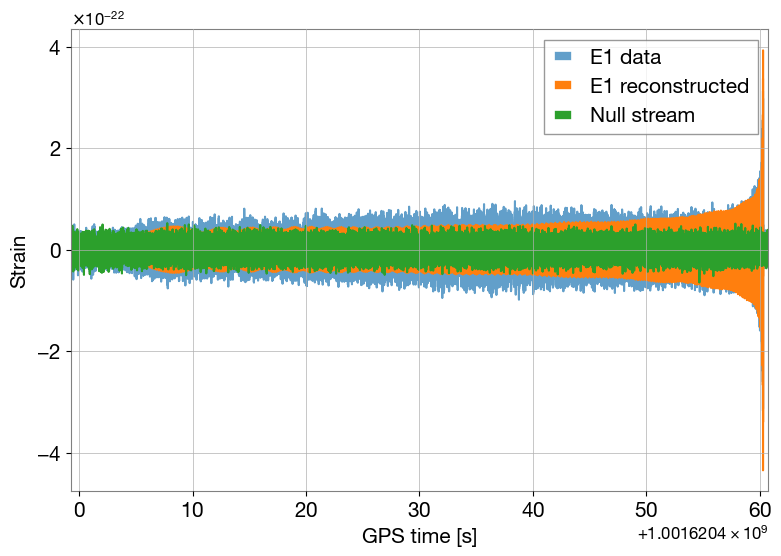

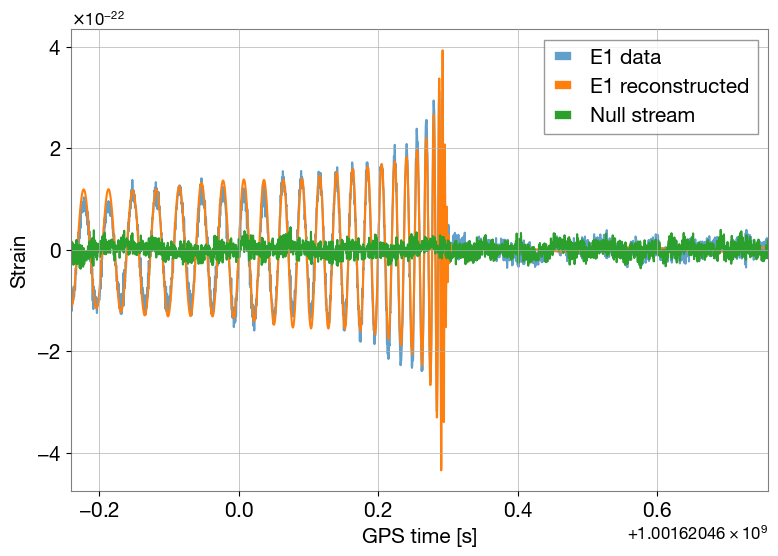

In [83]:
tsd_r = signal_reconstructed['E1'].to_timeseries() # Reconstructed time series in E1
tsd = tsd1.bandpass(4,1024) # Original E1 time series (bandpassed for visualization)
tsd_null = (tsd1 + tsd2 + tsd3) / np.sqrt(3) # Null stream time series (order of magnitude of the noise)
tsd_null = tsd_null.bandpass(4,1024)

plt.figure(figsize=(9,6))
ax = plt.gca()
plt.plot(tsd.times.value, tsd, alpha=0.7, label='E1 data')
ax.plot(tsd_r.get_sample_times(), tsd_r, label='E1 reconstructed')
ax.plot(tsd_null.times.value, tsd_null, label='Null stream')
ax.set_xlim(t0_loudest, tc_loudest1+0.5)
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

# Zoom on the merger
plt.figure(figsize=(9,6))
ax = plt.gca()
plt.plot(tsd.times.value, tsd, alpha=0.7, label='E1 data')
ax.plot(tsd_r.get_sample_times(), tsd_r, label='E1 reconstructed')
ax.plot(tsd_null.times.value, tsd_null, label='Null stream')
ax.set_xlim(tc_loudest1-0.5, tc_loudest1+0.5)
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

Text(0, 0.5, 'Strain')

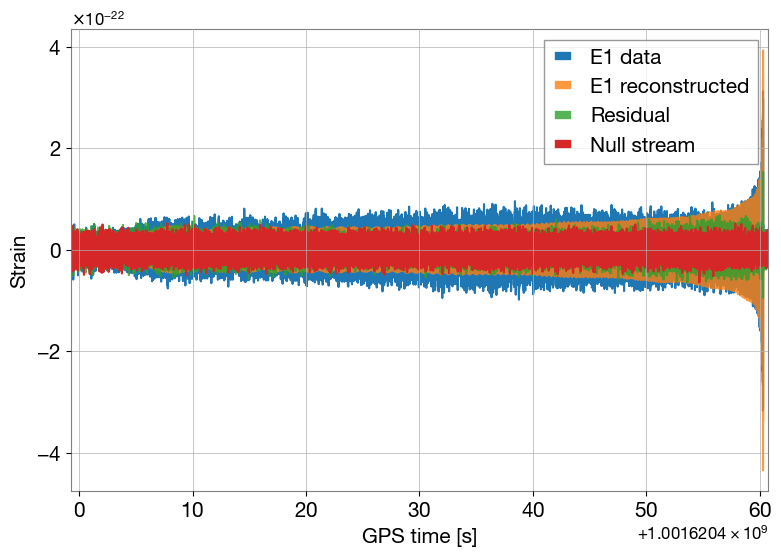

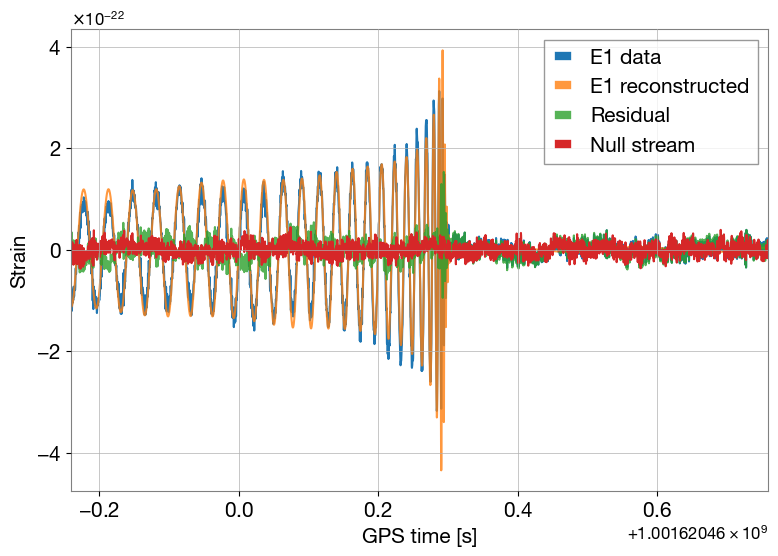

In [89]:
t1 = tsd.times.value
t2 = tsd_r.get_sample_times().data

h1 = tsd.value
h2 = tsd_r.data

from scipy.interpolate import interp1d

h_of_t = interp1d(t2, h2, bounds_error=False, fill_value=0)
h_new = h_of_t(t1)

residual = TimeSeries(h1 - h_new, times=t1)

plt.figure(figsize=(9,6))
ax = plt.gca()
ax.plot(t1, h1, label='E1 data')
ax.plot(t1, h_new, alpha=0.8, label='E1 reconstructed')
ax.plot(t1, h1 - h_new, alpha=0.8, label='Residual')
ax.plot(tsd_null.times, tsd_null, label='Null stream')
ax.set_xlim(t0_loudest, tc_loudest1+0.5)

ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

plt.figure(figsize=(9,6))
ax = plt.gca()
ax.plot(t1, h1, label='E1 data')
ax.plot(t1, h_new, alpha=0.8, label='E1 reconstructed')
ax.plot(t1, h1 - h_new, alpha=0.8, label='Residual')
ax.plot(tsd_null.times, tsd_null, label='Null stream')
ax.set_xlim(tc_loudest1-0.5, tc_loudest1+0.5)

ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

## Frequency domain

Text(0, 0.5, 'PSD [1/Hz]')

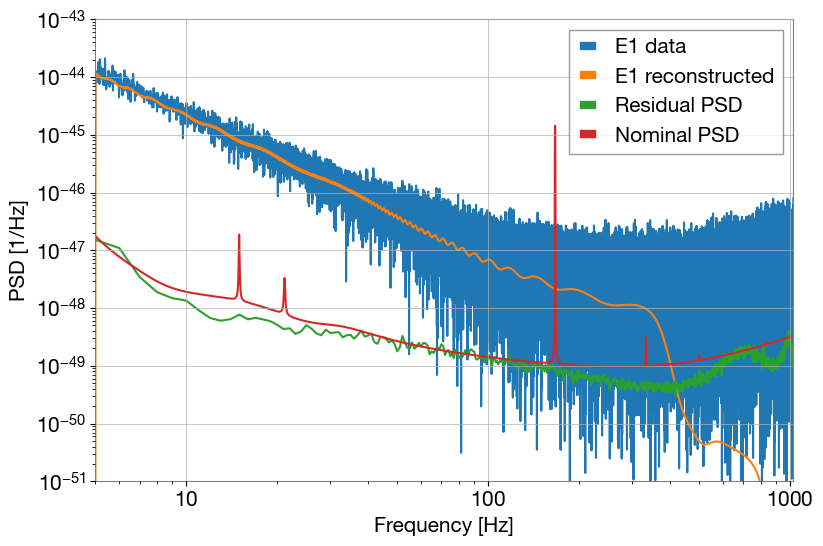

In [91]:
residual_psd = residual.psd(1.0)

plt.figure(figsize=(9,6))
ax = plt.gca()
ax.loglog(fft['E1'].get_sample_frequencies(), np.abs(fft['E1'])**2, label='E1 data')
ax.loglog(signal_reconstructed['E1'].get_sample_frequencies(), np.abs(signal_reconstructed['E1'])**2, label='E1 reconstructed')
ax.loglog(residual_psd.frequencies, residual_psd, label='Residual PSD')
ax.loglog(psd['E1'].get_sample_frequencies(), psd['E1'], label='Nominal PSD')
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlim(5, 1024)
ax.set_ylim(1e-51, 1e-43)
ax.set_xlabel('Frequency [Hz]', fontsize=15)
ax.set_ylabel('PSD [1/Hz]', fontsize=15)

## Conclusion